## Laboratorio 3 - Deep Learning
Stefano Aragoni, Carol Arevalo

-----------------

En parejas, utilicen la serie de tiempo en Monthly Sunspots y realicen el siguiente ejercicios:
Implemente 3 redes neuronales con las siguientes estructuras para resolver el problema de regresión:

1. Feed Forward NN (Red Simple)
2. RNN
3. LSTM

Documente sus resultados, discuta pros y contras de utilizar cada arquitectura y justifique cual sería su
elección para resolver este problema basado en los resultados obtenidos y la teoría revisada en clase.

---------------

#### Importar librerías



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dense, BatchNormalization, GaussianDropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, PReLU, ELU
from keras.layers import Activation

2023-08-14 10:04:12.918008: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


---------------

#### Importar Datos y Limpieza de Datos

In [2]:
#Cargar los datos
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv"
data = pd.read_csv(url)

data.head()

,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0


In [3]:
# Convertir Month en datetime
data['Date'] = pd.to_datetime(data['Month'])
data = data.drop('Month', axis=1)

# Reordenar columnas
cols = list(data.columns.values)
cols.pop(cols.index('Sunspots'))
data = data[cols+['Sunspots']]

# Ordenar por fecha
data = data.sort_values(by='Date')

data.head(-5)

,Date,Sunspots
0,1749-01-01,58.0
1,1749-02-01,62.6
2,1749-03-01,70.0
3,1749-04-01,55.7
4,1749-05-01,85.0
...,...,...
2810,1983-03-01,66.5
2811,1983-04-01,80.7
2812,1983-05-01,99.2
2813,1983-06-01,91.1


<AxesSubplot: >

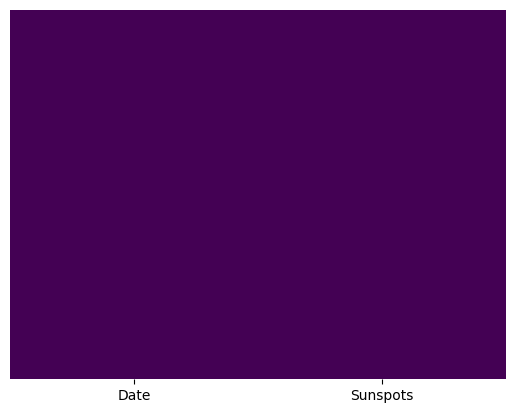

In [4]:
# Revisar datos faltantes
sns.heatmap(data.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')


In [5]:
# Escalar / Normalizar datos
scaler = MinMaxScaler(feature_range=(0, 1))

sunspots = data['Sunspots'].values
sunspots_normalizado = scaler.fit_transform(sunspots.reshape(-1, 1))     # Normalizar datos de Sunspots de 0 a 1

# Agregar datos normalizados a dataframe
data['Sunspots'] = sunspots_normalizado

data.head(-5)

,Date,Sunspots
0,1749-01-01,0.228526
1,1749-02-01,0.246651
2,1749-03-01,0.275808
3,1749-04-01,0.219464
4,1749-05-01,0.334909
...,...,...
2810,1983-03-01,0.262017
2811,1983-04-01,0.317967
2812,1983-05-01,0.390859
2813,1983-06-01,0.358944


---------------

#### Creacion de conjuntos de prueba, validacion, entrenamiento

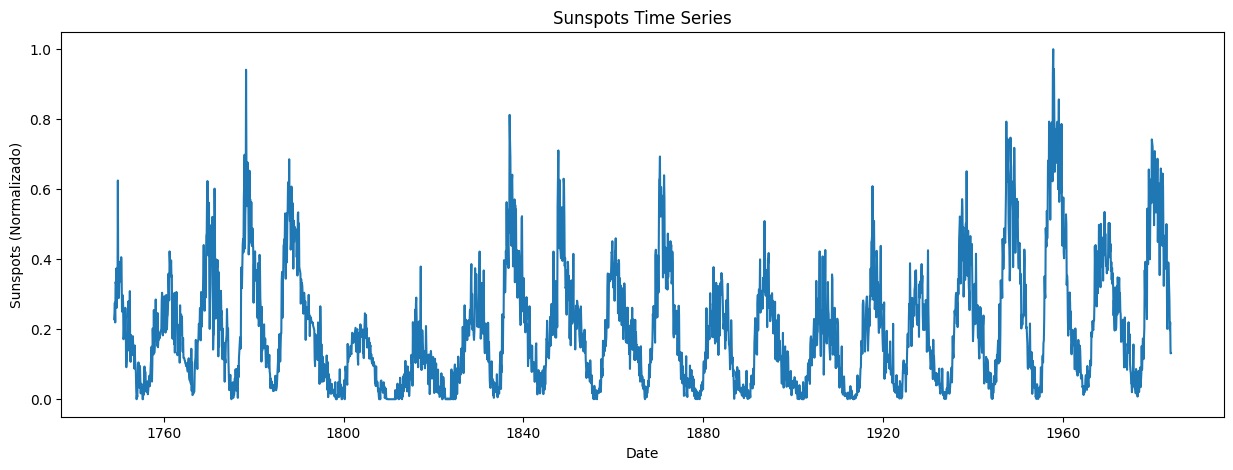

In [6]:
# Graficar el dataset X = fecha, Y = Sunspots_Normalizado

plt.figure(figsize=(15, 5))
plt.plot(data['Date'], data['Sunspots'])
plt.title('Sunspots Time Series')
plt.xlabel('Date')
plt.ylabel('Sunspots (Normalizado)')
plt.show()

In [7]:
#### Referencias 
#https://www.datacamp.com/tutorial/tutorial-for-recurrent-neural-network

# Separa los datos a partir de una fecha
def date_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", 'Sunspots'].values
    test = dataset.loc[f"{tend+1}":, 'Sunspots'].values
    return train, test

training_set, test_set = date_split(data, 1749, 1912)         # Genera el traning set de 1749 a 1912 y el test set de 1913 a 1983

In [8]:
# Crea las secuencias para el entrenamiento y prueba de la red neuronal
def create_sequences(data, time_steps):
    sequences = []
    for i in range(len(data) - time_steps):
        sequence = data[i:i+time_steps]
        target = data[i+time_steps]
        sequences.append((sequence, target))
    return sequences

time_steps = 20  # Cantidad de fechas a considerar para predecir la siguiente
training_sequences = create_sequences(training_set, time_steps)
testing_sequences = create_sequences(test_set, time_steps)

# Crea los arreglos de entrenamiento y prueba
X_train = np.array([sequence for sequence, target in training_sequences])
y_train = np.array([target for sequence, target in training_sequences])
X_test = np.array([sequence for sequence, target in testing_sequences])
y_test = np.array([target for sequence, target in testing_sequences])

# Separar X_test y y_test en dos partes iguales, para tener un conjunto de validación
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

In [9]:
# Verificar el contenido de X_test, y_test
print(X_test[0], "\n------------------")
print(y_test[0])

# Incluye los valores de Sunspots normalizados, sin la fecha. 

[0.18951931 0.15563436 0.35657998 0.34239559 0.12726556 0.17927502
 0.15563436 0.22340426 0.18360914 0.26122931 0.12726556 0.14184397
 0.08904649 0.14105595 0.09101655 0.15287628 0.23010244 0.21985816
 0.21355398 0.10401891] 
------------------
0.12411347517730495


---------------

## Redes Neuronales

Objetivo: Resolver el problema de regresión

### Red Neuronal 1: Feed Forward NN (Red Simple)

- Funciones de activación:
    - RELU
    - Sigmoid
- Números de capas y neuronas:
    - 1 capa con 64 neuronas
    - 1 capa oculta con 32 neuronas
    - 1 capa de salida con 1 neurona

In [52]:
model_ffnn = Sequential([
    Dense(64, activation='relu', input_shape=(time_steps, 1)),
    Dense(32, activation='sigmoid'),
    Dense(1)
])

Epoch 1/20
9/9 [==============================] - 1s 24ms/step - loss: 0.8742 - val_loss: 1.0951
Epoch 2/20
9/9 [==============================] - 0s 7ms/step - loss: 0.5781 - val_loss: 0.7465
Epoch 3/20
9/9 [==============================] - 0s 7ms/step - loss: 0.3493 - val_loss: 0.4799
Epoch 4/20
9/9 [==============================] - 0s 8ms/step - loss: 0.1899 - val_loss: 0.2898
Epoch 5/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0892 - val_loss: 0.1674
Epoch 6/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0370 - val_loss: 0.0973
Epoch 7/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0154 - val_loss: 0.0631
Epoch 8/20
9/9 [==============================] - 0s 8ms/step - loss: 0.0105 - val_loss: 0.0489
Epoch 9/20
9/9 [==============================] - 0s 8ms/step - loss: 0.0099 - val_loss: 0.0451
Epoch 10/20
9/9 [==============================] - 0s 9ms/step - loss: 0.0101 - val_loss: 0.0452
Epoch 11/20
9/9 [=====================

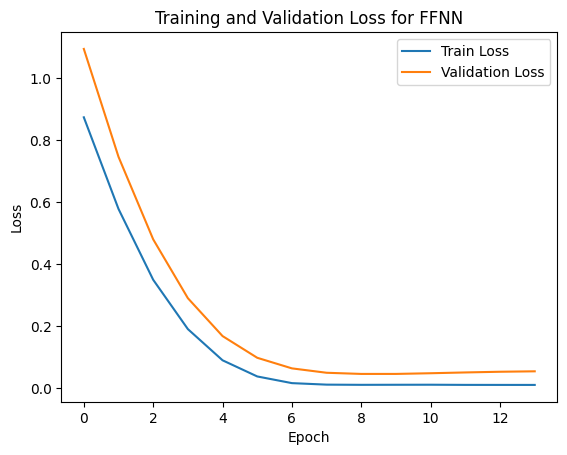

FFNN - Validation Loss (MSE): 0.0536
FFNN - Test Loss (MSE): 0.0153


In [53]:
model_ffnn.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo FFNN
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
history_ffnn = model_ffnn.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)

# Evaluar el modelo FFNN en los datos de prueba
test_loss_ffnn = model_ffnn.evaluate(X_test, y_test, verbose=0)

# Graficar la pérdida durante el entrenamiento para el modelo FFNN
plt.plot(history_ffnn.history['loss'], label='Train Loss')
plt.plot(history_ffnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss for FFNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Imprimir los resultados
print(f'FFNN - Validation Loss (MSE): {history_ffnn.history["val_loss"][-1]:.4f}')
print(f'FFNN - Test Loss (MSE): {test_loss_ffnn:.4f}')

------------
### Red Neuronal 2: RNN

- Funciones de activación:
    - RELU
    - Sigmoid
- Números de capas y neuronas:
    - 1 capa con 64 neuronas
    - 1 capa oculta con 32 neuronas
    - 1 capa de salida con 1 neurona

In [110]:
model_rnn = Sequential([
    SimpleRNN(64, activation='relu', input_shape=(time_steps, 1), return_sequences=True),
    SimpleRNN(32, activation='sigmoid'),
    Dense(1)
])

Epoch 1/20
9/9 [==============================] - 3s 58ms/step - loss: 0.0714 - val_loss: 0.2681
Epoch 2/20
9/9 [==============================] - 0s 19ms/step - loss: 0.0222 - val_loss: 0.1519
Epoch 3/20
9/9 [==============================] - 0s 22ms/step - loss: 0.0109 - val_loss: 0.0982
Epoch 4/20
9/9 [==============================] - 0s 20ms/step - loss: 0.0103 - val_loss: 0.0934
Epoch 5/20
9/9 [==============================] - 0s 19ms/step - loss: 0.0088 - val_loss: 0.0940
Epoch 6/20
9/9 [==============================] - 0s 36ms/step - loss: 0.0076 - val_loss: 0.0801
Epoch 7/20
9/9 [==============================] - 0s 21ms/step - loss: 0.0053 - val_loss: 0.0604
Epoch 8/20
9/9 [==============================] - 0s 19ms/step - loss: 0.0035 - val_loss: 0.0490
Epoch 9/20
9/9 [==============================] - 0s 19ms/step - loss: 0.0031 - val_loss: 0.0421
Epoch 10/20
9/9 [==============================] - 0s 23ms/step - loss: 0.0032 - val_loss: 0.0400
Epoch 11/20
9/9 [============

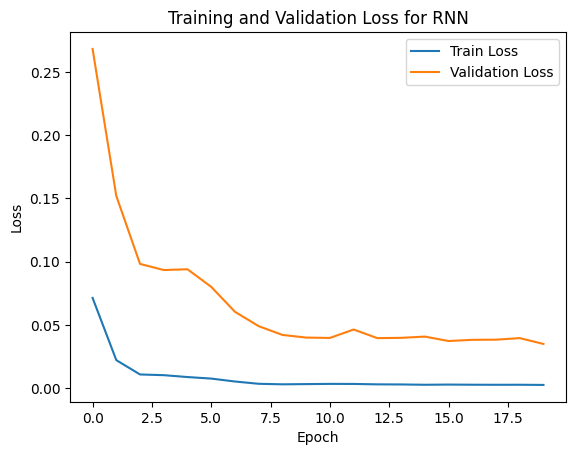

RNN - Validation Loss (MSE): 0.0350
RNN - Test Loss (MSE): 0.0062


In [111]:
model_rnn.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo RNN
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
history_rnn = model_rnn.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)

# Evaluar el modelo RNN en los datos de prueba
test_loss_rnn = model_rnn.evaluate(X_test, y_test, verbose=0)

# Graficar la pérdida durante el entrenamiento para el modelo RNN
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss for RNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Imprimir los resultados
print(f'RNN - Validation Loss (MSE): {history_rnn.history["val_loss"][-1]:.4f}')
print(f'RNN - Test Loss (MSE): {test_loss_rnn:.4f}')


-------------
### Red Neuronal 3: LSTM

- Funciones de activación:
    - RELU
    - Sigmoid
- Números de capas y neuronas:
    - 1 capa con 64 neuronas
    - 1 capa oculta con 32 neuronas
    - 1 capa de salida con 1 neurona

In [98]:
model_lstm = Sequential([
    LSTM(64, activation='relu', input_shape=(time_steps, 1), return_sequences=True),
    LSTM(32, activation='sigmoid'),
    Dense(1)
])

Epoch 1/20
9/9 [==============================] - 3s 76ms/step - loss: 0.0099 - val_loss: 0.0766
Epoch 2/20
9/9 [==============================] - 0s 27ms/step - loss: 0.0092 - val_loss: 0.0798
Epoch 3/20
9/9 [==============================] - 0s 27ms/step - loss: 0.0078 - val_loss: 0.0601
Epoch 4/20
9/9 [==============================] - 0s 31ms/step - loss: 0.0069 - val_loss: 0.0289
Epoch 5/20
9/9 [==============================] - 0s 27ms/step - loss: 0.0049 - val_loss: 0.0198
Epoch 6/20
9/9 [==============================] - 0s 26ms/step - loss: 0.0040 - val_loss: 0.0232
Epoch 7/20
9/9 [==============================] - 0s 30ms/step - loss: 0.0039 - val_loss: 0.0169
Epoch 8/20
9/9 [==============================] - 0s 25ms/step - loss: 0.0039 - val_loss: 0.0185
Epoch 9/20
9/9 [==============================] - 0s 28ms/step - loss: 0.0042 - val_loss: 0.0165
Epoch 10/20
9/9 [==============================] - 0s 42ms/step - loss: 0.0036 - val_loss: 0.0146
Epoch 11/20
9/9 [============

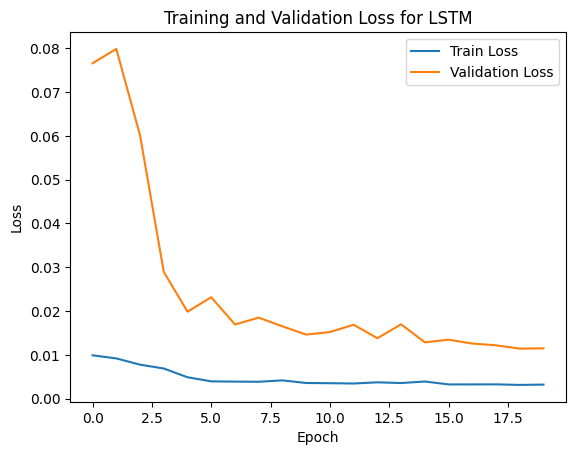

LSTM - Validation Loss (MSE): 0.0115
LSTM - Test Loss (MSE): 0.0055


In [99]:
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo LSTM
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
history_lstm = model_lstm.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)

# Evaluar el modelo LSTM en los datos de prueba
test_loss_lstm = model_lstm.evaluate(X_test, y_test, verbose=0)

# Graficar la pérdida durante el entrenamiento para el modelo LSTM
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss for LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Imprimir los resultados
print(f'LSTM - Validation Loss (MSE): {history_lstm.history["val_loss"][-1]:.4f}')
print(f'LSTM - Test Loss (MSE): {test_loss_lstm:.4f}')
